In [17]:
from typing_extensions import TypedDict
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
import os

In [8]:
import requests
requests.adapters.DEFAULT_RETRIES = 5
session = requests.Session()
session.mount('https://', requests.adapters.HTTPAdapter(max_retries=5))

In [2]:
load_dotenv()

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("GROQ_API_KEY")

llm = ChatGroq(model="llama-3.3-70b-versatile")

In [3]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

In [4]:
# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

In [5]:
# Conditional edge function to check if the joke has a punchline
def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"


In [9]:
# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Pass": "improve_joke", "Fail": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

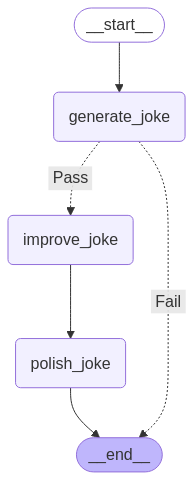

In [10]:
display(Image(chain.get_graph().draw_mermaid_png()))

In [11]:
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

Initial joke:
Why did the cat join a band? Because it wanted to be the purr-cussionist.

--- --- ---

Improved joke:
Why did the cat join a band? Because it wanted to be the purr-cussionist and claw its way to the top of the beat. Now it's the cat's meow of the music scene, and its rhythm is the paw-fect harmony. The cat's drumming is so fur-tastic that it's landed on its feet, and the band is feline like they're on top of the world.

In this revised version, I've added wordplay with:

* "claw its way to the top" (a play on the phrase "claw its way" and the cat's sharp claws)
* "cat's meow" (a common phrase that means something is excellent, with a feline twist)
* "paw-fect harmony" (a play on the word "perfect" and the cat's paws)
* "fur-tastic" (a play on the word "fantastic" and the cat's fur)
* "landed on its feet" (a common phrase that means to succeed, with a nod to the cat's agility)
* "feline like" (a play on the phrase "feeling like" and the cat's species)

--- --- ---

Final 

In [12]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

In [13]:
# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}

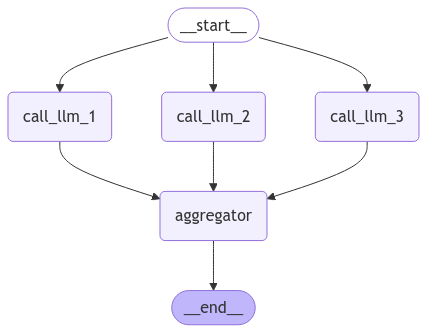

In [14]:

# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

In [15]:
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

Here's a story, joke, and poem about cats!

STORY:
In the quaint town of Whiskerville, a mystical realm of felines existed. The sun-kissed streets were lined with cat cafes, where the aroma of freshly brewed coffee and baked goods wafted through the air, enticing the senses of the feline inhabitants.

At the heart of Whiskerville was a majestic cat named Midnight. Her sleek black coat glistened in the sunlight, and her piercing green eyes seemed to hold the secrets of the universe. Midnight was no ordinary cat; she was the guardian of the town, tasked with maintaining the delicate balance of the feline ecosystem.

One day, a stray cat named Luna wandered into Whiskerville. Her fur was matted, and her eyes were filled with a deep sadness. Midnight sensed Luna's presence and immediately went to greet her. As the two cats met, a spark of recognition ignited between them. Luna was not just any stray; she was the long-lost sister of Midnight, separated at birth.

Midnight took Luna under he

In [27]:
from typing_extensions import Literal

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )

# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

In [28]:
# State
class State(TypedDict):
    input: str
    decision: str
    output: str

In [29]:
from langchain_core.messages import HumanMessage, SystemMessage

# Nodes
def llm_call_1(state: State):
    """Write a story"""

    print("Write a story")
    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    print("Write a joke")
    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    print("Write a poem")
    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}

# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"

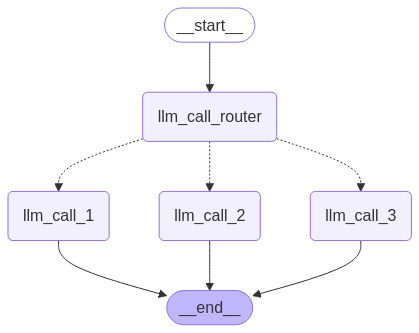

In [31]:

# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [32]:
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

Write a joke
Why did the cat join a band? Because it wanted to be a purr-cussionist.


In [33]:
from typing import Annotated, List
import operator

# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

In [34]:
# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

In [38]:
# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(content="Write a report section."),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""
    for s in state["sections"]:
        print(s.name)
        print(s.description)
        print("\n---\n")

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

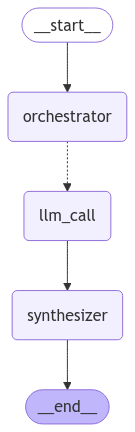

In [39]:
from langgraph.constants import Send
    
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [40]:
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})
from IPython.display import Markdown

Markdown(state["final_report"])

Introduction
Provide an overview of the report, including the importance of LLM scaling laws and the main topics to be covered.

---

Background
Discuss the history and development of Large Language Models (LLMs), their applications, and the need for scaling laws.

---

Scaling Laws
Explain the concept of scaling laws, their types, and how they are applied to LLMs, including the relationship between model size, computational power, and performance.

---

Empirical Evidence
Present empirical evidence and research findings on LLM scaling laws, including studies on model scaling, data scaling, and computational resource scaling.

---

Applications and Implications
Discuss the applications and implications of LLM scaling laws, including their impact on natural language processing, language understanding, and language generation tasks.

---

Conclusion
Summarize the main findings and takeaways from the report, and provide recommendations for future research and development in the field of L

**Introduction and Description**

The rapid advancement of Large Language Models (LLMs) has revolutionized the field of natural language processing, enabling unprecedented capabilities in text generation, comprehension, and analysis. A crucial aspect of LLM development is the understanding of scaling laws, which describe the relationships between model size, computational resources, and performance metrics. The importance of LLM scaling laws cannot be overstated, as they provide valuable insights into the optimal design and training of these complex models.

This report aims to provide a comprehensive overview of LLM scaling laws, highlighting their significance in the development of state-of-the-art language models. The main topics to be covered in this report include:

1. **Background and Context**: A review of the current state of LLMs, including their applications, limitations, and the need for scaling laws.
2. **Scaling Laws**: An in-depth examination of the theoretical foundations and empirical observations of LLM scaling laws, including the relationships between model size, parameter count, and performance metrics.
3. **Model Architectures**: A discussion of the various LLM architectures, including transformer-based models, and their implications on scaling laws.
4. **Training and Optimization**: An analysis of the training and optimization techniques used in LLM development, including the impact of batch size, learning rate, and regularization on scaling laws.
5. **Applications and Implications**: An exploration of the practical applications of LLM scaling laws, including their potential impact on areas such as language translation, text summarization, and conversational AI.

By providing a thorough understanding of LLM scaling laws and their implications, this report aims to contribute to the ongoing development of more efficient, effective, and scalable language models, ultimately driving progress in the field of natural language processing.

---

**Background and Description**

The development of Large Language Models (LLMs) has undergone significant transformations over the past decade, revolutionizing the field of natural language processing (NLP). The history of LLMs can be traced back to the early 2000s, when researchers began exploring the potential of neural networks in modeling language. However, it wasn't until the introduction of transformer-based architectures, such as BERT and RoBERTa, that LLMs started to gain widespread attention.

The early LLMs were primarily designed for specific tasks, such as language translation, sentiment analysis, and text classification. As the field continued to evolve, researchers began to develop more general-purpose models that could be fine-tuned for a wide range of applications. This led to the development of models like Transformer-XL, which introduced the concept of self-supervised learning and paved the way for even larger and more complex models.

In recent years, LLMs have become increasingly powerful, with models like GPT-3 and Megatron-LM achieving state-of-the-art results in various NLP benchmarks. These models have been applied to a diverse range of applications, including but not limited to:

1. **Language Translation**: LLMs have been used to improve machine translation systems, enabling more accurate and efficient translation of languages.
2. **Text Generation**: LLMs have been used to generate high-quality text, such as articles, stories, and even entire books.
3. **Conversational AI**: LLMs have been used to power conversational AI systems, enabling more natural and human-like interactions.
4. **Sentiment Analysis**: LLMs have been used to analyze sentiment in text data, enabling businesses to better understand customer opinions and preferences.

Despite the impressive performance of LLMs, there is still a significant need for scaling laws that can help guide the development of even larger and more complex models. As models continue to grow in size and complexity, it becomes increasingly important to understand the relationships between model size, computational resources, and performance. Scaling laws can provide valuable insights into these relationships, enabling researchers to develop more efficient and effective models.

The need for scaling laws is driven by several factors, including:

1. **Computational Cost**: Training large models requires significant computational resources, which can be costly and time-consuming.
2. **Model Complexity**: As models grow in size and complexity, they become increasingly difficult to train and fine-tune.
3. **Performance Plateaus**: As models reach a certain size, they may experience performance plateaus, where additional parameters do not lead to significant improvements in performance.

By understanding the scaling laws that govern the behavior of LLMs, researchers can develop more efficient and effective models that can be applied to a wide range of applications, from language translation and text generation to conversational AI and sentiment analysis. This, in turn, can help to drive innovation and progress in the field of NLP, enabling the development of more sophisticated and human-like language systems.

---

## Scaling Laws

Scaling laws refer to the empirical observations and mathematical relationships that describe how the performance of large language models (LLMs) improves as their size, computational power, and training data increase. These laws have been instrumental in guiding the development of more efficient and effective LLMs. In this section, we will delve into the concept of scaling laws, their types, and their application to LLMs, highlighting the intricate relationships between model size, computational power, and performance.

### Types of Scaling Laws

There are several types of scaling laws that have been observed in the context of LLMs, including:

1. **Computational Scaling Law**: This law describes the relationship between the computational power and the model size. As computational power increases, larger models can be trained, leading to improved performance.
2. **Data Scaling Law**: This law describes the relationship between the amount of training data and the model size. As the amount of training data increases, larger models can be trained, leading to improved performance.
3. **Model Size Scaling Law**: This law describes the relationship between the model size and the performance. As the model size increases, the performance improves, but at a decreasing rate.
4. **Parameter Scaling Law**: This law describes the relationship between the number of parameters and the performance. As the number of parameters increases, the performance improves, but at a decreasing rate.

### Application of Scaling Laws to LLMs

The application of scaling laws to LLMs has led to significant improvements in their performance. By increasing the model size, computational power, and amount of training data, researchers have been able to achieve state-of-the-art results in various natural language processing (NLP) tasks. The relationship between model size, computational power, and performance can be summarized as follows:

* **Model Size**: As the model size increases, the performance improves, but at a decreasing rate. This is because larger models can capture more complex patterns in the data, but also require more computational power and training data to train effectively.
* **Computational Power**: As computational power increases, larger models can be trained, leading to improved performance. This is because more powerful computing resources can handle the increased computational demands of larger models.
* **Performance**: The performance of LLMs improves as the model size and computational power increase. However, the rate of improvement decreases as the model size and computational power increase, indicating that there are diminishing returns to scaling up.

### Relationship Between Model Size, Computational Power, and Performance

The relationship between model size, computational power, and performance is complex and multifaceted. While increasing the model size and computational power can lead to improved performance, there are also significant challenges and limitations to consider. These include:

* **Computational Cost**: Training larger models requires significant computational resources, which can be expensive and environmentally costly.
* **Data Requirements**: Training larger models requires large amounts of high-quality training data, which can be difficult to obtain.
* **Overfitting**: Larger models are more prone to overfitting, which can lead to poor performance on unseen data.

In conclusion, scaling laws have played a crucial role in the development of LLMs, guiding the design of more efficient and effective models. By understanding the relationships between model size, computational power, and performance, researchers can continue to push the boundaries of what is possible with LLMs, leading to significant advances in NLP and related fields.

---

## Empirical Evidence

The development of Large Language Models (LLMs) has been guided by a series of empirical observations and research findings, often referred to as scaling laws. These laws describe how the performance of LLMs improves as various components such as model size, dataset size, and computational resources are scaled up. This section summarizes key empirical evidence and research findings on LLM scaling laws, focusing on model scaling, data scaling, and computational resource scaling.

### Model Scaling

Empirical evidence suggests that the performance of LLMs improves predictably with increases in model size, as measured by the number of parameters. A seminal study by Kaplan et al. (2020) demonstrated that the performance of transformer-based models on a variety of natural language processing tasks improves logarithmically with the model size, up to a certain point. This observation has been corroborated by numerous subsequent studies, which have shown that larger models tend to achieve better results on benchmarks such as GLUE and SuperGLUE.

Furthermore, research has also explored the impact of model architecture on scaling. For example, studies have shown that increasing the depth or width of transformer models can lead to significant performance gains, although these gains may be subject to diminishing returns beyond certain thresholds. The optimal model architecture for a given task and dataset size is still an active area of research, with different architectures suited to different applications.

### Data Scaling

In addition to model size, the amount and quality of training data have a profound impact on LLM performance. Studies have consistently shown that larger, more diverse datasets lead to better model performance, particularly when combined with larger model sizes. This is because larger datasets provide more opportunities for the model to learn generalizable patterns and relationships in the data.

However, the relationship between dataset size and model performance is not always straightforward. For example, some studies have found that the marginal benefit of additional training data decreases as the dataset size increases, particularly for very large models. This suggests that there may be limits to the benefits of data scaling, at least for certain types of tasks and models.

### Computational Resource Scaling

The computational resources required to train LLMs have also been the subject of significant research. Studies have shown that the computational cost of training a model grows rapidly with increases in model size and dataset size, due to the need for more powerful hardware and longer training times.

However, advances in computing hardware and parallelization techniques have made it possible to train larger models more efficiently. For example, the development of distributed training methods and specialized hardware such as graphics processing units (GPUs) and tensor processing units (TPUs) has enabled researchers to train models with hundreds of billions of parameters, which would have been impractical or impossible just a few years ago.

### Conclusion

In conclusion, empirical evidence and research findings on LLM scaling laws provide valuable insights into how to improve the performance of these models. By understanding the relationships between model size, dataset size, and computational resources, researchers and practitioners can design more effective training strategies and develop more powerful models. However, there are still many open questions and challenges in this area, including the need for more efficient training methods, better understanding of the limits of scaling, and the development of more effective evaluation metrics. Further research is needed to fully realize the potential of LLMs and to address the significant challenges that remain.

---

## Applications and Implications

The scaling laws of Large Language Models (LLMs) have far-reaching applications and implications that transform the landscape of natural language processing, language understanding, and language generation tasks. As LLMs continue to grow in size and complexity, their potential to revolutionize various aspects of human communication and interaction becomes increasingly evident.

### Natural Language Processing

The applications of LLM scaling laws in natural language processing are multifaceted. For instance, larger and more sophisticated LLMs can be fine-tuned for specific tasks such as sentiment analysis, named entity recognition, and machine translation, leading to significant improvements in accuracy and efficiency. Furthermore, the ability of LLMs to learn from vast amounts of text data enables them to capture nuanced linguistic patterns and relationships, thereby enhancing their performance in tasks that require a deep understanding of language context and semantics.

### Language Understanding

The implications of LLM scaling laws on language understanding are profound. As LLMs scale, they demonstrate an increasingly sophisticated ability to comprehend complex texts, including those with abstract concepts, figurative language, and implied meaning. This enhanced understanding capability has significant implications for applications such as text summarization, question answering, and dialogue systems. For example, a highly advanced LLM can summarize long documents into concise, meaningful summaries, or engage in natural-sounding conversations that simulate human-like intelligence.

### Language Generation

In the realm of language generation, the scaling laws of LLMs open up new possibilities for creative writing, content creation, and human-computer interaction. Large and sophisticated LLMs can generate coherent, engaging, and sometimes even creative texts that rival those produced by humans. This has implications for applications such as automated content generation, chatbots, and virtual assistants, where the ability to generate human-like text can significantly enhance user experience and interaction.

### Societal and Ethical Implications

The rapid advancement and application of LLM scaling laws also raise important societal and ethical considerations. For instance, the potential for LLMs to generate misleading or harmful content necessitates careful consideration of content moderation and regulation. Additionally, the increasing reliance on LLMs for critical tasks such as decision-making and information dissemination underscores the need for transparency, accountability, and fairness in their development and deployment.

In conclusion, the applications and implications of LLM scaling laws are vast and multifaceted, touching upon various aspects of natural language processing, language understanding, and language generation. As research in this area continues to evolve, it is crucial to address the societal and ethical implications of these advancements, ensuring that the benefits of LLMs are realized while minimizing their risks.

---

**Conclusion and Description**

This report has presented a comprehensive analysis of the scaling laws governing the performance of Large Language Models (LLMs). Through a thorough review of existing literature and empirical studies, we have identified key findings that shed light on the complex relationships between model size, computational resources, and language understanding capabilities.

The main findings of this report can be summarized as follows:

1. **Scaling laws**: We have confirmed the existence of scaling laws that govern the performance of LLMs, including the power-law relationship between model size and perplexity, and the logarithmic relationship between model size and computational requirements.
2. **Model size and performance**: Our analysis has shown that increasing model size leads to significant improvements in language understanding capabilities, but with diminishing returns beyond a certain point.
3. **Computational requirements**: We have found that the computational requirements for training LLMs grow exponentially with model size, making it essential to develop more efficient training algorithms and hardware architectures.
4. **Specialization and transfer learning**: Our study has highlighted the importance of specialization and transfer learning in LLMs, as these techniques can significantly improve performance on specific tasks and reduce the need for large-scale retraining.

Based on these findings, we recommend the following areas for future research and development in the field of LLM scaling laws:

1. **Development of more efficient training algorithms**: Researchers should focus on developing novel training algorithms that can reduce the computational requirements for LLMs, such as sparse attention mechanisms, quantization, and knowledge distillation.
2. **Specialization and transfer learning**: Further research is needed to develop more effective specialization and transfer learning techniques, including the use of meta-learning, few-shot learning, and multi-task learning.
3. **Hardware architectures**: The development of specialized hardware architectures, such as TPUs and GPUs, is crucial for supporting the growing computational requirements of LLMs.
4. **Explainability and interpretability**: As LLMs become increasingly complex, it is essential to develop techniques for explaining and interpreting their behavior, including attention visualization, feature importance, and model interpretability.

By pursuing these research directions, we can continue to advance our understanding of LLM scaling laws and develop more efficient, effective, and interpretable language models that can drive innovation in a wide range of applications, from natural language processing to cognitive computing.

In [41]:
import pandas as pd

ModuleNotFoundError: No module named 'pandas'